In [1]:
%matplotlib widget
from src.utils import *
from src.contracts import *

Consider a contract for bounding a battery charging behavior where `soc*` variables represent the battery state-of-charge, `t*` variables represent time, `duration*` represents the duration of the contract between `t*_entry` and `t*_exit`. The `s` index allwos for creating distinct copies of this contract for modeling distinct occurrences.

In [2]:
c1: PolyhedralContract = charging(s=1, generation=[0.5, 0.8])
print(f"c1:\n{c1}")

c1:
InVars: [t1_entry, t1_var, duration1, soc1_entry]
OutVars:[t1_exit, soc1_var, soc1_exit]
A: [
  -duration1 <= -0
  -t1_entry <= -0
  t1_entry - t1_var <= 0
  -soc1_entry <= -0
  soc1_entry <= 100
]
G: [
  0.8 duration1 + soc1_entry <= 100
  duration1 + t1_entry - t1_exit = 0
  0.5 duration1 + soc1_entry - soc1_exit <= 0
  -0.8 duration1 - soc1_entry + soc1_exit <= 0
  soc1_entry - soc1_var - 0.5 t1_entry + 0.5 t1_var <= 0
  -soc1_entry + soc1_var + 0.8 t1_entry - 0.8 t1_var <= 0
  -t1_exit + t1_var <= 0
  -soc1_exit + soc1_var <= 0
]


To use a contract for simulation purposes, we need to extract its `PolyhedralTermList`: the list of all assumptions and guarantees constraints.

In [3]:
constraints: PolyhedralTermList = c1.a | c1.g
print(f"constraints:\n{constraints}")

constraints:
[
  -duration1 <= -0
  -t1_entry <= -0
  t1_entry - t1_var <= 0
  -soc1_entry <= -0
  soc1_entry <= 100
  0.8 duration1 + soc1_entry <= 100
  duration1 + t1_entry - t1_exit = 0
  0.5 duration1 + soc1_entry - soc1_exit <= 0
  -0.8 duration1 - soc1_entry + soc1_exit <= 0
  soc1_entry - soc1_var - 0.5 t1_entry + 0.5 t1_var <= 0
  -soc1_entry + soc1_var + 0.8 t1_entry - 0.8 t1_var <= 0
  -t1_exit + t1_var <= 0
  -soc1_exit + soc1_var <= 0
]


We can refine this list of constraints in a particular context of values for the exogeneous variables (`duration1`, `t1_entry`, `soc1_exit`); which is a subset of the contract's input variables.
We also need to eliminate the "exit" variables that represent the bounds on the contract: `t1_exit` and `soc1_exit`.

In [4]:
ce: PolyhedralTermList = constraints \
.evaluate({
    Var("duration1"): 10.0,
    Var("t1_entry"): 0,
    Var("soc1_entry"): 50.0,
}) \
.simplify() \
.elim_vars_by_relaxing(context=PolyhedralTermList([]), vars_to_elim=[Var("soc1_exit"), Var("t1_exit")]) 
print(f"ce:\n{ce}")

ce:
[
  -soc1_var + 0.5 t1_var <= -50
  soc1_var - 0.8 t1_var <= 50
  t1_var <= 10
]


Notice that the resulting constraints specify the bounds on the output variable, `soc1_var`, as a linear function of the input variable, `t1_var`. 

In [5]:
t_var_min, t_var_max = get_bounds(ce, "t1_var")
print(f"t1_var:[{t_var_min},{t_var_max}]")

soc1_var_min, soc1_var_max = get_bounds(ce, "soc1_var")
print(f"soc1_var (ce) :[{soc1_var_min},{soc1_var_max}]")

t1_var:[0.0,10.0]
soc1_var (ce) :[50.0,58.0]


We can evaluate the refined constraints for a specific value of the simulation input, `t1_var`, to get bounds on the simulation output, `soc1_var`.

In [6]:
x_var=Var("t1_var")
y_var=Var("soc1_var")

soc1_var_min, soc1_var_max = calculate_output_bounds_for_input_value(ce, {x_var: 4.0}, y_var)
print(f"soc1_var (ce1):[{soc1_var_min},{soc1_var_max}]")

soc1_var (ce1):[52.0,53.2]


Interactive simulation plot: click anywhere to show the range of values for the given input value

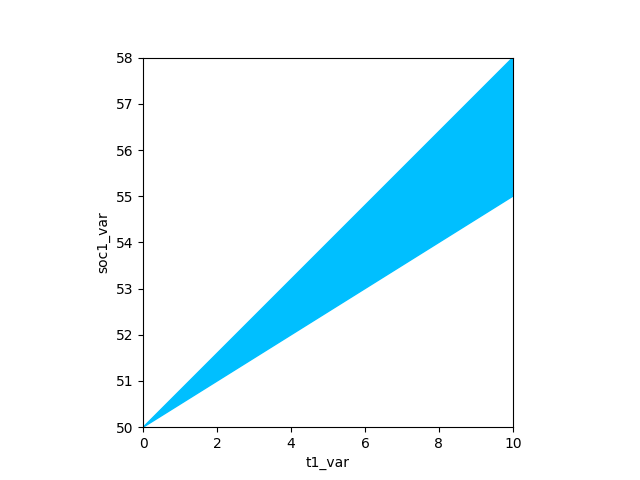

In [7]:
fig = plot_input_output_polyhedral_term_list(ce, x_var, y_var)